In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
class Residual(nn.Module):
    def __init__(self,input_channels,num_channels,use_1x1conv=False,strides=1):
        super().__init__()
        self.conv1=nn.Conv2d(input_channels,num_channels,kernel_size=3,padding=1,stride=strides)
        self.conv2=nn.Conv2d(num_channels,num_channels,kernel_size=3,padding=1)
        if use_1x1conv:
            self.conv3=nn.Conv2d(input_channels,num_channels,kernel_size=1,stride=strides)
        else:
            self.conv3 =None
        self.bn1=nn.BatchNorm2d(num_channels)
        self.bn2=nn.BatchNorm2d(num_channels)
        
    def forward(self,X):
        Y=F.relu(self.bn1(self.conv1(X)))
        Y=self.bn2(self.conv2(Y))
        if self.conv3:
            X=self.conv3(X)
        Y+=X
        return F.relu(Y)

In [3]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [4]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [5]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3),
                    nn.BatchNorm2d(64), nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
def resnet_block(input_channels,num_channels,num_residuals,first_block=False):
    blk=[]
    for i in range(num_residuals):
        if i==0 and not first_block:
            blk.append(Residual(input_channels,num_channels,use_1x1conv=True,strides=2))
        else:
            blk.append(Residual(num_channels,num_channels))
    return blk

In [7]:
b2=nn.Sequential(*resnet_block(64,64,3,first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 4))
b4 = nn.Sequential(*resnet_block(128, 256, 6))
b5 = nn.Sequential(*resnet_block(256, 512, 3))

In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [9]:
X = torch.rand(size=(1, 3, 32, 32))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 16, 16])
Sequential output shape:	 torch.Size([1, 64, 16, 16])
Sequential output shape:	 torch.Size([1, 128, 8, 8])
Sequential output shape:	 torch.Size([1, 256, 4, 4])
Sequential output shape:	 torch.Size([1, 512, 2, 2])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [15]:
net.state_dict()

OrderedDict([('0.0.weight',
              tensor([[[[-0.0512, -0.0313,  0.0809,  ..., -0.0761,  0.0721,  0.0544],
                        [-0.0491,  0.0531, -0.0045,  ...,  0.0593, -0.0518, -0.0099],
                        [ 0.0427,  0.0384,  0.0461,  ..., -0.0184, -0.0629, -0.0149],
                        ...,
                        [ 0.0749,  0.0444,  0.0344,  ..., -0.0357,  0.0387,  0.0813],
                        [ 0.0362, -0.0708, -0.0718,  ..., -0.0287, -0.0418, -0.0397],
                        [-0.0780, -0.0031,  0.0158,  ..., -0.0093, -0.0104,  0.0383]],
              
                       [[ 0.0295, -0.0055, -0.0321,  ..., -0.0522,  0.0662, -0.0009],
                        [ 0.0581, -0.0490,  0.0399,  ...,  0.0059,  0.0043,  0.0488],
                        [ 0.0306,  0.0822,  0.0309,  ...,  0.0501,  0.0310, -0.0535],
                        ...,
                        [-0.0387,  0.0466,  0.0349,  ..., -0.0149,  0.0779, -0.0642],
                        [-0.0779, -0.0

loss 0.012, train acc 0.997, test acc 0.918
4044.3 examples/sec on cuda:0


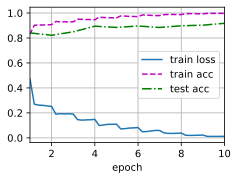

In [10]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())